C:\Users\lsrin\AppData\Local\Temp\ipykernel_5544\350768403.py:85: RuntimeWarning: invalid value encountered in scalar subtract
  delta = max(delta, abs(v - V[s]))


Model-Based Total Reward: 3


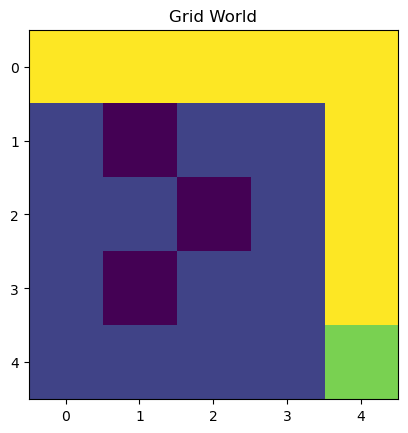

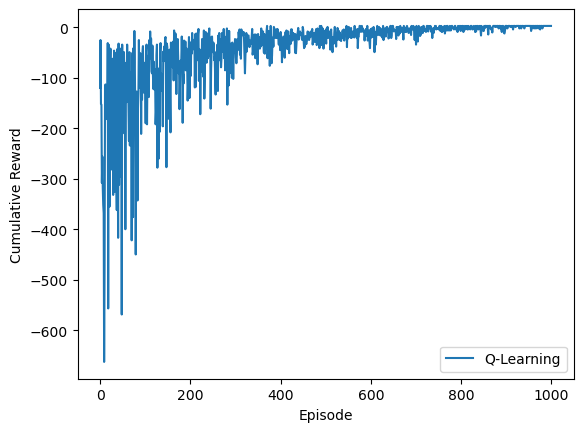

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.state = (0, 0)
        self.goal = (size - 1, size - 1)
        self.obstacles = set([(1, 1), (2, 2), (3,1)])
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]

    def reset(self):
        self.state = (0, 0)
        return self.state

    def step(self, action_index):
        action = self.actions[action_index]
        new_state = (self.state[0] + action[0], self.state[1] + action[1])

        if not (0 <= new_state[0] < self.size and 0 <= new_state[1] < self.size) or new_state in self.obstacles:
            reward = -5
            return self.state, reward, False
        else:
            self.state = new_state
            if self.state == self.goal:
                reward = 10
                return self.state, reward, True
            else:
                reward = -1
                return self.state, reward, False

    def render(self, path=None):
        grid = np.zeros((self.size, self.size))
        for obs in self.obstacles:
            grid[obs] = -1
        grid[self.goal] = 2
        grid[self.state] = 3
        if path:
            for p in path[:-1]:
                grid[p] = 4
        plt.imshow(grid, cmap='viridis')
        plt.title("Grid World")
        plt.show()

# Model Learning and Policy Iteration
def train_model_and_policy(env, num_experience=1000, gamma=0.9, theta=1e-4):
    model = {}
    state = env.reset()
    for _ in range(num_experience):
        action_index = random.randint(0, 3)
        next_state, reward, done = env.step(action_index)
        if (state, action_index) not in model:
            model[(state, action_index)] = {}
        if (next_state, reward) not in model[(state, action_index)]:
            model[(state, action_index)][(next_state, reward)] = 0
        model[(state, action_index)][(next_state, reward)] += 1
        state = next_state

    for key in model: #Normalize model
        total = sum(model[key].values())
        for next_state_reward in model[key]:
            model[key][next_state_reward] /= total

    policy = np.zeros((env.size, env.size), dtype=int)
    V = np.zeros((env.size, env.size))
    while True:
        delta = 0
        for s_row in range(env.size):
            for s_col in range(env.size):
                s = (s_row, s_col)
                v = V[s]
                best_action = 0
                max_val = -np.inf
                for a in range(4):
                    if (s, a) in model:
                        val = 0
                        for next_state_reward, prob in model[(s, a)].items():
                            next_state, reward = next_state_reward
                            val += prob * (reward + gamma * V[next_state])
                        if val > max_val:
                            max_val = val
                            best_action = a
                V[s] = max_val
                delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
        for s_row in range(env.size):
            for s_col in range(env.size):
                s = (s_row, s_col)
                best_action = 0
                max_val = -np.inf
                for a in range(4):
                    if (s, a) in model:
                        val = 0
                        for next_state_reward, prob in model[(s, a)].items():
                            next_state, reward = next_state_reward
                            val += prob * (reward + gamma * V[next_state])
                        if val > max_val:
                            max_val = val
                            best_action = a
                policy[s] = best_action
    return policy, model

# Model-Free (Q-Learning)
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon_start=1.0, epsilon_end=0.01):
    q_table = np.zeros((env.size, env.size, 4))
    rewards_per_episode = []
    epsilon_decay = (epsilon_start - epsilon_end) / num_episodes
    epsilon = epsilon_start
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            state_row, state_col = state
            if random.random() < epsilon:
                action = random.randint(0, 3)
            else:
                action = np.argmax(q_table[state_row, state_col])

            next_state, reward, done = env.step(action)
            next_state_row, next_state_col = next_state

            q_table[state_row, state_col, action] += alpha * (reward + gamma * np.max(q_table[next_state_row, next_state_col]) - q_table[state_row, state_col, action])
            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        epsilon = max(epsilon_end, epsilon - epsilon_decay) #Decay epsilon
    return q_table, rewards_per_episode

# Run and Evaluate
env = GridWorld()
model_policy, model = train_model_and_policy(env)
q_table, q_rewards = q_learning(env)

# Model-Based Trajectory and Reward
state = env.reset()
path = [state]
total_reward_mb = 0
done = False
while not done:
    row, col = state
    action = model_policy[row, col]
    next_state, reward, done = env.step(action)
    path.append(next_state)
    total_reward_mb += reward
    state = next_state

print("Model-Based Total Reward:", total_reward_mb)
env.render(path)

#Plot rewards
plt.plot(q_rewards, label = "Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()